In [1]:
#!pip install --upgrade pip
#!pip install -U numpy
#!pip install gensim 
#!pip install spacy==2.0.10
#!pip install greenlet
#!pip install allennlp --user
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html

### Cuda Nightly
"cuda_8": "https://download.pytorch.org/whl/nightly/cu80/torch_nightly.html",  
"cuda_9": "https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html",  
"cuda_10": "https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html",  
"no_cuda": "https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html",  

In [71]:
# Torch, Sklearn imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
## AllenNLP
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from allennlp.modules.token_embedders import BertEmbedder

print("PyTorch: {}".format(torch.__version__))
print("AllenNLP: {}".format(allennlp.__version__))
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print("Using CUDA device: {}".format(device))
    print("- # GPU device: {}".format(torch.cuda.device_count()))
    print("- Device Name: {}".format(torch.cuda.get_device_name(device)))
    print("- Device Proprierties: {}".format(torch.cuda.get_device_properties(device)))

PyTorch: 1.0.0.dev20190207
AllenNLP: 0.8.1
Using CUDA device: 0
- # GPU device: 1
- Device Name: Tesla K80
- Device Proprierties: _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [4]:
## NLP libs
from nltk import download
import gensim
from nltk.corpus import stopwords
download('stopwords')

## Sklearn imports
from sklearn.datasets import fetch_20newsgroups

## General libs
import numpy as np
import pandas as pd
from string import punctuation
import os, re, sys, json, requests, pickle

02/07/2019 17:23:26 - INFO - gensim.summarization.textcleaner -   'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def transformText(text, do_stop=False, do_stem=False, do_lema = False):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()
    
    # Removing E-mails  
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    text = re.sub(r'\S*@\S*\s?', r' ', text)
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Removing Newline
    text = text.rstrip()
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Stemming
    if (do_stem==True):
        text = gensim.parsing.preprocessing.stem_text(text)
    
    # Lemmatization
    if (do_lema==True):
        text = do_lemmatization(text)   
        
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    return text

In [6]:
## Lemmatization function based on Spacy Library
def lemmatizer_spacy(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [7]:
dataset = pd.read_csv('dataset/intents_train_roberto.csv', sep=';')
dataset.rename(index=str, columns={"Intent": "intent", "result": "phrases"},inplace=True)
dataset['clean_text']=dataset['phrases'].apply(lambda x: transformText(x))## Suffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [8]:
## Test current model accuracy
with open('dataset/intents_test_roberto.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [72]:
## Build word vocabulary
word_to_ix = {}
for sent in dataset.clean_text:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print("Tamanho do dicionario: {}".format(len(word_to_ix)))
## Build label vocabulary
label_to_ix = {}
for label in dataset.intent:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
print("Tamanho dos labels: {}".format(len(label_to_ix)))

data_split = int(0.8*len(dataset))
train_dataset = dataset[:data_split]
valid_dataset = dataset[data_split:-1].reset_index(drop=True)

Tamanho do dicionario: 764
Tamanho dos labels: 169


In [10]:
len(train_dataset), len(valid_dataset)

(1981, 495)

In [11]:
for i in list(set(train_dataset.intent))[0:10]:
    print("LABEL {} - PHRASES {}".format(i,len(train_dataset[train_dataset.intent==i])))

LABEL jobRequisition.update - PHRASES 14
LABEL jobRequisition.hold - PHRASES 11
LABEL associateGovernmentRegistration.create - PHRASES 23
LABEL workerTobaccoUsageStatus.update - PHRASES 21
LABEL legalEntity.delete - PHRASES 10
LABEL view.job - PHRASES 5
LABEL worker.usI9Screening.section1.generate - PHRASES 12
LABEL workerMaritalStatus.update - PHRASES 31
LABEL workerBusinessContactInformation.update - PHRASES 12
LABEL paymentDate.update - PHRASES 1


In [12]:
## ELMo
#elmo_weights_key_path = '../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
#elmo_config_key_path = '../vectors/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'

## S3 Configs for SageMaker
bucket = 'adp-e-ml-notebooks-sagemaker'             
prefix = 'vectors'   
elmo_weights_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'.format(prefix)
elmo_weights_key_path = os.path.join('s3://', bucket, elmo_weights_key)
elmo_config_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'.format(prefix)
elmo_config_key_path = os.path.join('s3://', bucket, elmo_config_key)

### Elmo Instance
elmo = Elmo(elmo_config_key_path, 
            elmo_weights_key_path, 
            num_output_representations = 1, 
            dropout=0.3,
            requires_grad = False)
if torch.cuda.is_available():
    elmo = elmo.cuda()

02/07/2019 17:23:36 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [39]:
def get_elmo_unorm(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    return avg

In [40]:
get_elmo_unorm("what is love baby don't hurt me").mean()

tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
get_elmo_unorm("what is").mean()

tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
def get_elmo(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    avg = avg/torch.norm(avg)
    return avg

In [43]:
get_elmo("what is love baby don't hurt me").mean()

tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)

In [44]:
get_elmo("what is").mean()

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [45]:
class Intents(Dataset):
    def __init__(self, dataframe, embed_type):
        self.len = len(dataframe)
        self.label_to_ix = {}
        self.data = dataframe
        self.embed_type = embed_type
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        if self.embed_type == 'bert':
            X = get_features(phrase, max_seq_length, out_layers, zero_pad, include_special_tokens)
        elif self.embed_type == 'w2v':        
            X = get_avg_sentence_vector(phrase)
        elif self.embed_type == 'elmo':
            X = get_elmo(phrase)
        y = label_to_ix[self.data.intent[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [46]:
training_set = Intents(train_dataset,"elmo")
validing_set = Intents(valid_dataset, "elmo")

In [47]:
training_set.__getitem__(1)

(tensor([-0.0372, -0.0264,  0.0192,  ..., -0.0050, -0.0060, -0.0044],
        device='cuda:0', grad_fn=<DivBackward0>), 1)

In [48]:
validing_set.__getitem__(400)

(tensor([-0.0359,  0.0054,  0.0088,  ..., -0.0668, -0.0019, -0.0838],
        device='cuda:0', grad_fn=<DivBackward0>), 10)

## Simple MLP Classifier

In [49]:
class SimpleMLP(nn.Module):
    def __init__(self, inputdim, 
                        nclasses, 
                        nhidden, 
                        dropout = 0):
        super(SimpleMLP, self).__init__()
        """
        PARAMETERS:
        -dropout:    dropout for MLP
        """
        
        self.inputdim = inputdim
        self.hidden_dim = nhidden
        self.dropout = dropout
        self.nclasses = nclasses
        self.model = nn.Sequential(
            nn.Linear(self.inputdim, nhidden),
            nn.Dropout(p=self.dropout),
            nn.ReLU(),
            nn.Linear(nhidden, self.nclasses),
            )
        if torch.cuda.is_available():
            self.model = self.model.cuda()
    def forward(self, x):
        log_probs = self.model(x)
        return log_probs

In [50]:
INP_DIM = elmo.get_output_dim()
NUM_LABELS = len(label_to_ix)
NHIDDEN = 256
DROPOUT = 0

In [51]:
model = SimpleMLP(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model = model.to(device)
    model.cuda()

## Training

In [52]:
# Dataloaders Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 0}
train_loader = DataLoader(training_set, **params)
valid_loader = DataLoader(validing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [53]:
max_epochs = 10
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(train_loader):
        optimizer.zero_grad() 
        if torch.cuda.is_available():
            sent = sent.cuda()
            label = label.cuda()
        output = model.forward(sent)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if i%100 == 0:      
            correct = 0
            total = 0
            for sent, label in valid_loader:      
                if torch.cuda.is_available():
                    sent = sent.cuda()
                    label = label.cuda()
                output = model.forward(sent)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('LOSS: {}. VALID ACCURACY: {}%'.format(loss.data, accuracy))

EPOCH -- 0
LOSS: 5.121843338012695. VALID ACCURACY: 1.6161616161616161%
LOSS: 4.92648983001709. VALID ACCURACY: 3.4343434343434343%
EPOCH -- 1
LOSS: 4.110687255859375. VALID ACCURACY: 12.121212121212121%
LOSS: 3.039674758911133. VALID ACCURACY: 15.95959595959596%
EPOCH -- 2
LOSS: 2.8082525730133057. VALID ACCURACY: 31.31313131313131%
LOSS: 1.914872169494629. VALID ACCURACY: 42.02020202020202%
EPOCH -- 3
LOSS: 1.950381875038147. VALID ACCURACY: 49.292929292929294%
LOSS: 1.4507930278778076. VALID ACCURACY: 54.343434343434346%
EPOCH -- 4
LOSS: 0.8552657961845398. VALID ACCURACY: 61.01010101010101%
LOSS: 0.7792470455169678. VALID ACCURACY: 62.42424242424242%
EPOCH -- 5
LOSS: 0.6008155345916748. VALID ACCURACY: 67.47474747474747%
LOSS: 0.6147715449333191. VALID ACCURACY: 72.72727272727273%
EPOCH -- 6
LOSS: 0.3915284276008606. VALID ACCURACY: 72.32323232323232%
LOSS: 0.4111880660057068. VALID ACCURACY: 74.54545454545455%
EPOCH -- 7
LOSS: 0.32204681634902954. VALID ACCURACY: 78.18181818181819

In [54]:
def get_reply(phrase, model):
    x = get_elmo(phrase)
    logits_out = model.forward(x)
    softmax_out = F.softmax(logits_out, dim=0).cpu()
    _, pred_label = torch.max(softmax_out.data, 0)
    prediction=list(label_to_ix.keys())[pred_label]
    return prediction

In [55]:
get_reply("demote worker", model)

'demote'

In [56]:
get_reply("change my email", model)

'personPersonalEmail.update'

## Checking test error

In [57]:
correct = 0
total = 0
errors = []
for phrase, label in test_dataset:
    phrase_transformed = transformText(phrase)
    prediction = get_reply(phrase_transformed, model)
    total +=1
    if prediction == label:
        correct += 1
    else:
        errors.append((sent,label))
test_accuracy = 100.00 * correct / total
print("TEST ACCURACY  -- {}".format(test_accuracy))

TEST ACCURACY  -- 75.20661157024793


## Implementing Augmentation Class

In [58]:
%matplotlib inline
from torch.nn.functional import interpolate
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [59]:
def get_linear_interpolation(label, num_interp_samples, return_all_points=False):
    sentences= list(train_dataset.clean_text[train_dataset.intent == label])
    points = np.zeros((elmo.get_output_dim(),len(sentences)))    
    
    for i,utt in enumerate(sentences):
        points[:,i] = get_elmo(utt).detach().cpu().clone().numpy()
    point = torch.tensor(points)
    x = point.unsqueeze(dim=0) 
    
    ## Random selector for which interpolated phrase to pick
    rand_phrase = np.random.randint(num_interp_samples, size = 1)
    
    ## Interpolate phrases
    interp = interpolate(x, size=(num_interp_samples), mode='linear', align_corners=True).squeeze(0).numpy().T
    
    if return_all_points == False:
        interp =interp[rand_phrase].squeeze(0)      ## Pick Randomly 1 point sample
    return interp

In [60]:
get_linear_interpolation('transfer', num_interp_samples = 20).shape

(1024,)

In [61]:
get_linear_interpolation('transfer', num_interp_samples = 20, return_all_points=True).shape

(20, 1024)

In [62]:
def plot_manifold(intents, num_interp_samples, perplexity = 3):
    
    list_intents = {}
    for name in intents:
        phrases = list(dataset.clean_text[dataset.intent == name])
        list_intents.update({name:phrases})
    
    ## List all sentences
    sentences = [item for sublist in list(list_intents.values()) for item in sublist]
    embeddings_np = np.zeros((len(sentences), elmo.get_output_dim()))
    for i,sent in enumerate(sentences):
        embeddings_np[i]= get_elmo(sent).detach().cpu().numpy()
    initial_sent_size = len(sentences)
    
    ## Get syntetic phrases
    for name in list_intents:
        interp = get_linear_interpolation(name, num_interp_samples, return_all_points=True)
        embeddings_np = np.vstack((embeddings_np,interp))
        syntetic_label = "--- interp_{} ---".format(name)
        ## initial sizes
        for i in range(num_interp_samples):
            sentences.append(syntetic_label)

    ## Do TSNE and plot
    tsne=TSNE(n_components=2,perplexity = perplexity, method ='exact',verbose=1)
    sentences_tsne = tsne.fit_transform(embeddings_np)
    plt.subplots(figsize=(30, 15))
    plt.grid()
    
    ## Grouping points by indexes
    points = (sentences_tsne[:initial_sent_size,0], sentences_tsne[:initial_sent_size,1])
    syntetic_points = (sentences_tsne[initial_sent_size:,0], sentences_tsne[initial_sent_size:,1])
    
    ## Ploting points
    plt.scatter(points[0], points[1], c='r', marker='o')
    plt.scatter(syntetic_points[0], syntetic_points[1], c='b', marker='x')

    ## Adding labels
    for label, x, y in zip(sentences[0:initial_sent_size], points[0], points[1]):
        font = {'size' : 10, 'weight' : 'normal'}
        plt.rc('font', **font)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

    for label, x, y in zip(sentences[initial_sent_size:], syntetic_points[0], syntetic_points[1]):
        font = {'size' : 18, 'weight' : 'bold'}
        plt.rc('font', **font)
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')



[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 41 / 41
[t-SNE] Mean sigma: 0.246920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.645409
[t-SNE] Error after 1000 iterations: 0.338210


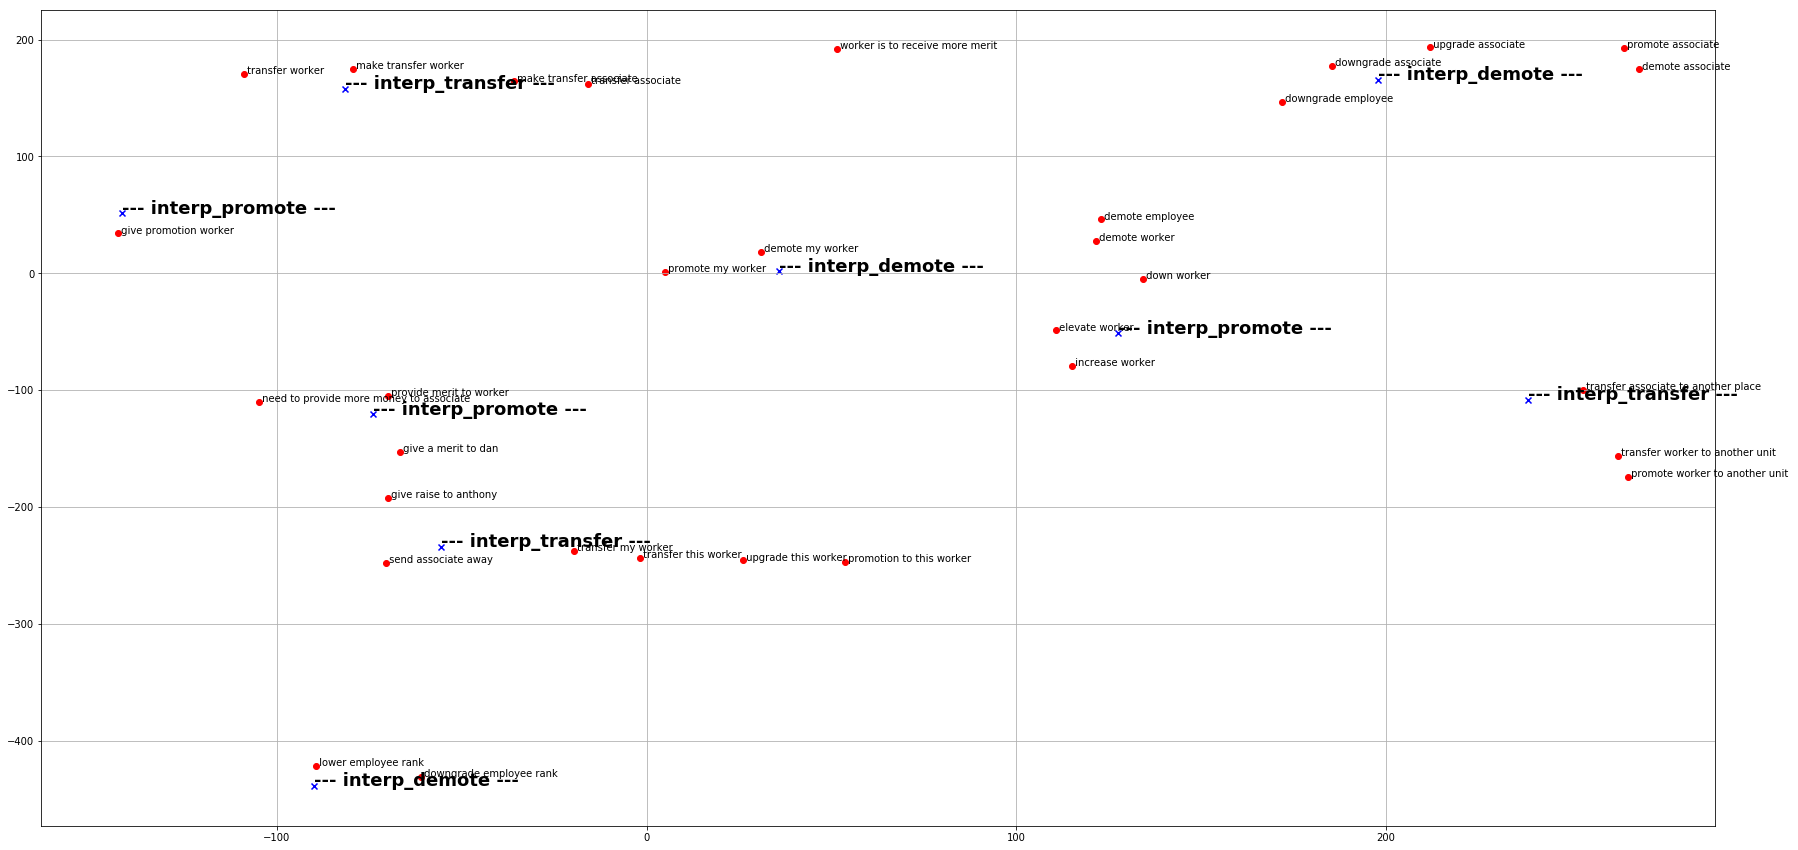

In [63]:
plot_manifold(["promote", "demote", "transfer"], 3, perplexity = 3)

In [82]:
class AugmentedIntents(Dataset):
    def __init__(self, dataframe, alpha, num_samples = 20, augmentation = True):
        self.len = len(dataframe)
        self.label_to_ix = {}
        self.data = dataframe
        self.augmentation = augmentation
        self.num_samples = num_samples
        self.alpha = alpha                          ## probabilty to get a real phrase vs interpolated phrase
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        label = self.data.intent[index]
        y = label_to_ix[label]
        if self.augmentation:
            proba = np.random.binomial(1, self.alpha )
            if proba == 1:
                X = get_elmo(phrase)
            elif proba == 0:
                X = torch.tensor(get_linear_interpolation(label, num_interp_samples = self.num_samples), dtype=torch.float32)
                if torch.cuda.is_available():
                    X = X.cuda()
        else:
            X = get_elmo(phrase)
        return X, y
    
    def __len__(self):
        return self.len

In [83]:
alpha = 0.5
num_samples = 10
training_set = AugmentedIntents(train_dataset, alpha, num_samples, augmentation = True)
validing_set = AugmentedIntents(valid_dataset,  alpha, num_samples, augmentation = False)

In [84]:
n = training_set.__getitem__(1)

In [85]:
n[0].shape

torch.Size([1024])

In [86]:
INP_DIM = elmo.get_output_dim()
NUM_LABELS = len(label_to_ix)
NHIDDEN = 256
DROPOUT = 0
model_2 = SimpleMLP(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model_2 = model_2.to(device)
    model_2.cuda()

In [87]:
# Dataloaders Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 0}
train_loader = DataLoader(training_set, **params)
valid_loader = DataLoader(validing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model_2.parameters(), lr=learning_rate)

In [88]:
max_epochs = 10
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(train_loader):        
        optimizer.zero_grad()
        if torch.cuda.is_available():
            sent = sent.cuda()
            label = label.cuda()
        output = model_2.forward(sent)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in valid_loader:
                if torch.cuda.is_available():
                    sent = sent.cuda()
                    label = label.cuda()
                output = model_2.forward(sent)
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('LOSS: {}. VALID ACCURACY: {}%'.format(loss.data, accuracy))

EPOCH -- 0
LOSS: 5.155913829803467. VALID ACCURACY: 1.0101010101010102%
LOSS: 5.082685947418213. VALID ACCURACY: 5.454545454545454%
EPOCH -- 1
LOSS: 4.358635902404785. VALID ACCURACY: 8.686868686868687%
LOSS: 3.3360671997070312. VALID ACCURACY: 16.161616161616163%
EPOCH -- 2
LOSS: 3.5841145515441895. VALID ACCURACY: 26.86868686868687%
LOSS: 2.237826347351074. VALID ACCURACY: 41.41414141414141%
EPOCH -- 3
LOSS: 1.4369903802871704. VALID ACCURACY: 47.27272727272727%
LOSS: 1.1743848323822021. VALID ACCURACY: 56.36363636363637%
EPOCH -- 4
LOSS: 0.6679232120513916. VALID ACCURACY: 63.23232323232323%
LOSS: 1.0622501373291016. VALID ACCURACY: 61.21212121212121%
EPOCH -- 5
LOSS: 0.6721732020378113. VALID ACCURACY: 69.29292929292929%
LOSS: 0.380768358707428. VALID ACCURACY: 72.12121212121212%
EPOCH -- 6
LOSS: 0.500145435333252. VALID ACCURACY: 74.74747474747475%
LOSS: 0.5111355781555176. VALID ACCURACY: 73.93939393939394%
EPOCH -- 7
LOSS: 0.3228610157966614. VALID ACCURACY: 77.57575757575758%
L

In [90]:
correct = 0
total = 0
errors = []
for phrase, label in test_dataset:
    phrase_transformed = transformText(phrase)
    prediction = get_reply(phrase_transformed, model_2)
    total +=1
    if prediction == label:
        correct += 1
    else:
        errors.append((sent,label))
test_accuracy = 100.00 * correct / total
print("TEST ACCURACY  -- {}".format(test_accuracy))

TEST ACCURACY  -- 70.24793388429752


### Results

- Linear

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % |
| --- | --- | --- | --- |
| <font color='red'> 1 (no augmentation) </font> |  -  | <font color='red'> **81.21**  </font>| <font color='red'> **75.20**  </font> |
| 0.5 | 5  | 79.79  | 73.55 |
| 0.5 | 10 | 80.80 | 70.24 |
| 0.5 | 30 | - | - |
| 0.5 | 50 | - | - |
| 0.7 | 5  | - | - |
| 0.7 | 10 | - | - |
| 0.7 | 30 | - | - |
| 0.7 | 50 | - | - |
| 0.9 | 5  | - | - |
| 0.9 | 10 | - | - |
| 0.9 | 30 | - | - |
| 0.9 | 50 | - | - |


- Nearest

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % |
| --- | --- | --- | --- |
| <font color='red'> 1 (no augmentation) </font>  |  -   | -  | - |
| 0.5 | 5  | -  | - |
| 0.5 | 10 | - | - |
| 0.5 | 30 | - | - |
| 0.5 | 50 | - | - |
| 0.7 | 5  | - | - |
| 0.7 | 10 | - | - |
| 0.7 | 30 | - | - |
| 0.7 | 50 | - | - |
| 0.9 | 5  | - | - |
| 0.9 | 10 | - | - |
| 0.9 | 30 | - | - |
| 0.9 | 50 | - | - |

- _Mixup_

| Alpha (Real/Sintetic) | Num Samples Interpolated | Valid Accuracy % | Test Accuracy % |
| --- | --- | --- | --- |
| <font color='red'> 1 (no augmentation) </font>  |  -   | -  | - |
| 0.5 | 5  | -  | - |
| 0.5 | 10 | - | - |
| 0.5 | 30 | - | - |
| 0.5 | 50 | - | - |
| 0.7 | 5  | - | - |
| 0.7 | 10 | - | - |
| 0.7 | 30 | - | - |
| 0.7 | 50 | - | - |
| 0.9 | 5  | - | - |
| 0.9 | 10 | - | - |
| 0.9 | 30 | - | - |
| 0.9 | 50 | - | - |